# Notebook for training lightgbm model

## Imports and constants

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import snappy
from fastparquet import ParquetFile
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [84]:
TRAIN_FILENAME = 'new_train_2sided_extended.snappy.parquet'
TEST_FILENAME = 'new_test_extended.snappy.parquet'
SPREAD_ID = 6
FUNDING_RATE_ID = 1
TIME_LEFT_ID = 5
COMMISION_VALUE = 0.08
POSITION_TYPE = 1
SHIFT = 64
SPLIT_PERCENTAGE = 0.95
BEST_MODEL_FILENAME = "model_boost500.txt"
ALLOWED_ACTION = -1

## Train and test data extraction

In [4]:
def snappy_decompress(data, uncompressed_size):
    return snappy.decompress(data)

In [10]:
train_pf = ParquetFile(TRAIN_FILENAME)
train = train_pf.to_pandas()

In [11]:
train.head()

,number_of_trades_p,funding_rate,volume_p,number_of_trades_q,volume_q,time_left,spread,price_change_d_max,price_change_d_min,target,...,price_change_d_min-62,number_of_trades_p-63,funding_rate-63,volume_p-63,number_of_trades_q-63,volume_q-63,time_left-63,spread-63,price_change_d_max-63,price_change_d_min-63
0,1424.0,0.000521,182.208,1.0,0.159,7121340.0,7.941044,-0.422779,-3.39489,1,...,-3.39489,4473.0,0.000521,400.630,4.0,0.059,7125120.0,7.852325,-0.422779,-3.39489
1,13102.0,0.000521,1149.350,63.0,1.205,7121280.0,7.878363,-0.422779,-3.39489,1,...,-3.39489,2854.0,0.000521,249.644,2.0,0.066,7125060.0,7.880229,-0.422779,-3.39489
2,14929.0,0.000521,1745.533,103.0,5.282,7121220.0,7.777068,-0.422779,-3.39489,1,...,-3.39489,2555.0,0.000521,214.457,6.0,0.353,7125000.0,7.892018,-0.422779,-3.39489
3,3982.0,0.000521,327.739,18.0,0.393,7121160.0,7.819870,-0.422779,-3.39489,1,...,-3.39489,1768.0,0.000521,148.087,12.0,0.330,7124940.0,7.902424,-0.422779,-3.39489
4,3526.0,0.000521,328.421,31.0,0.718,7121100.0,7.795760,-0.422779,-3.39489,1,...,-3.39489,2280.0,0.000521,172.108,2.0,0.017,7124880.0,7.962683,-0.422779,-3.39489


In [12]:
train.loc[:, 'target'].sum()

201646

In [13]:
test_pf = ParquetFile(TEST_FILENAME)
test = test_pf.to_pandas()

In [14]:
test.head()

,number_of_trades_p,funding_rate,volume_p,number_of_trades_q,volume_q,time_left,spread,price_change_d_max,price_change_d_min,number_of_trades_p-1,...,price_change_d_min-62,number_of_trades_p-63,funding_rate-63,volume_p-63,number_of_trades_q-63,volume_q-63,time_left-63,spread-63,price_change_d_max-63,price_change_d_min-63
0,216.0,0.000014,8.679,0.0,0.000,5788920.0,0.612377,0.0,-3.023083,272.0,...,-3.023083,163.0,0.000044,14.162,2.0,0.039,5792700.0,0.600157,0.0,-3.023083
1,148.0,0.000013,4.218,1.0,0.001,5788860.0,0.614598,0.0,-3.023083,216.0,...,-3.023083,133.0,0.000044,13.289,0.0,0.000,5792640.0,0.580793,0.0,-3.023083
2,11.0,0.000012,0.322,0.0,0.000,5788800.0,0.614562,0.0,-3.023083,148.0,...,-3.023083,117.0,0.000045,8.574,0.0,0.000,5792580.0,0.638621,0.0,-3.023083
3,390.0,0.000011,29.047,1.0,0.018,5788740.0,0.622014,0.0,-3.023083,11.0,...,-3.023083,725.0,0.000044,112.460,9.0,0.401,5792520.0,0.611762,0.0,-3.023083
4,243.0,0.000010,34.262,5.0,0.056,5788680.0,0.626171,0.0,-3.023083,390.0,...,-3.023083,258.0,0.000044,25.349,0.0,0.000,5792460.0,0.649675,0.0,-3.023083


## Spliting and creating datasets

In [18]:
split = int(SPLIT_PERCENTAGE*len(train))
split_id = train.index[split]

In [19]:
X_train = train.loc[:split_id, train.columns != 'target'].to_numpy()
X_val = train.loc[split_id:, train.columns != 'target'].to_numpy()
X_test = test.to_numpy()

y_train = train.loc[:split_id, ['target']].to_numpy()
y_val = train.loc[split_id:, ['target']].to_numpy()

In [20]:
train_dataset = lgb.Dataset(data = X_train, label = y_train, params = {'feature_pre_filter': False})
val_dataset = lgb.Dataset(data = X_val, label = y_val, reference=train_dataset, params = {'feature_pre_filter': False})

## Tuning, training and importing the saved model

In [85]:
booster = lgb.Booster(model_file=BEST_MODEL_FILENAME)

Uncomment if need to retrain

In [86]:
# params = {
#     'boosting': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'lambda_l1': 2.2143258800994073e-06,
#     'lambda_l2': 0.0005954224220656749,
#     'num_leaves': 3,
#     'n_estimators': 525,
#     'feature_fraction': 0.496380831756819,
#     'bagging_fraction': 0.721180374394912,
#     'bagging_freq': 1,
#     'min_child_samples': 74
# }
# booster = lgb.train(params, train_dataset, valid_sets=[train_dataset, val_dataset], verbose_eval=True)

Uncomment if need to retune

In [87]:
# def objective(trial):
#     param = {
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "feature_pre_filter": False,
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         'n_estimators': trial.suggest_int("n_estimators", 16, 1024),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     }

#     gbm = lgb.train(param, train_dataset)
#     y_val_pred = gbm.predict(X_val)
#     y_val_pred_labels = (np.rint(y_val_pred)).astype(int)
#     f1_score_ = f1_score(y_val, y_val_pred_labels)
#     return f1_score_

# import warnings
# warnings.filterwarnings('ignore')

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)

In [88]:
y_pred = booster.predict(X_val)

In [89]:
print(np.sum(y_pred))
y_pred_1 = (np.rint(y_pred)).astype(int)
print(np.sum(y_pred_1))

13009.015536890141
11441


In [90]:
print('counfusion matrix\n', confusion_matrix(y_val, y_pred_1), sep='')
print('\nf1_score =', f1_score(y_val, y_pred_1))
print('accuracy =', accuracy_score(y_val, y_pred_1))

counfusion matrix
[[20524 10116]
 [ 2407  1325]]

f1_score = 0.17465234297765767
accuracy = 0.6356627487489818


## Predicting

In [91]:
y_test = booster.predict(X_test)
print(np.sum(y_test))
y_test_1 = (np.rint(y_test)).astype(int)
print(np.sum(y_test_1))

17944.25194162522
16097


### Visualization of prediction

In [92]:
spreads = test.iloc[:, SPREAD_ID].to_numpy()
spread_0 = test.iloc[0, SPREAD_ID]
rewards_test = POSITION_TYPE * (spread_0 - spreads) - COMMISION_VALUE \
                    - POSITION_TYPE * test.iloc[:, FUNDING_RATE_ID].cumsum()

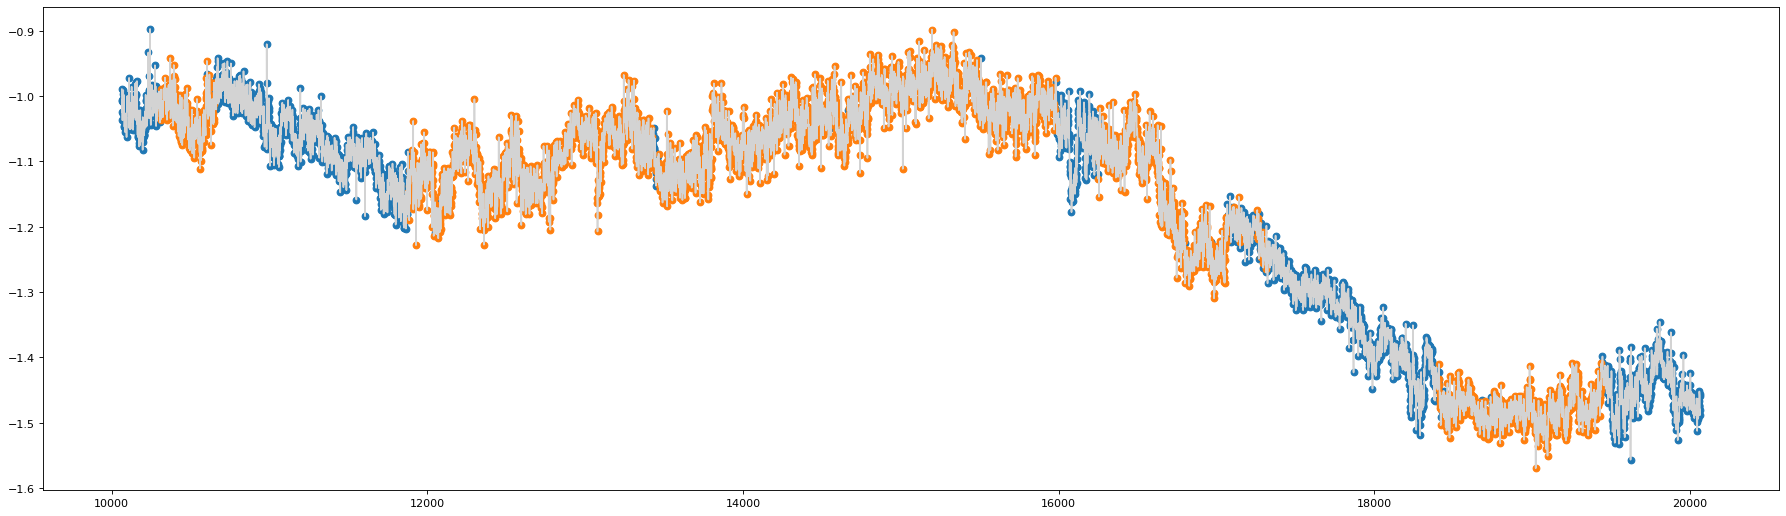

In [93]:
plot_start = 10000
plot_end = 20000

plt.figure(figsize=(28, 8), dpi=80)

plt.plot(test.index[plot_start  + SHIFT:plot_end+ SHIFT], rewards_test.iloc[plot_start + SHIFT:plot_end + SHIFT], c='lightgrey')
plt.scatter(test.index[plot_start  + SHIFT:plot_end + SHIFT][(y_test_1[plot_start  :plot_end] == 0).reshape(-1)], 
    rewards_test.iloc[plot_start + SHIFT:plot_end+ SHIFT][(y_test_1[plot_start :plot_end] == 0).reshape(-1)])
plt.scatter(test.index[plot_start  + SHIFT:plot_end+ SHIFT][(y_test_1[plot_start  : plot_end] == 1).reshape(-1)], 
    rewards_test.iloc[plot_start + SHIFT:plot_end+ SHIFT][(y_test_1[plot_start :plot_end] == 1).reshape(-1)])

## Evaluate

In [94]:
MAX_AVAILABLE_TIME_LEFT = 24 * 60 * 5
PREV_COUNT_FOR_CHANGE = 20
END = len(test)
VERBOSE = False

In [95]:
def calc_reward(action_type, df, start_i, end_i, verbose=False):
    spread_reward = action_type * (df.iloc[start_i, SPREAD_ID] - df.iloc[end_i, SPREAD_ID])
    funding_reward = - action_type * df.iloc[start_i:end_i, FUNDING_RATE_ID].sum()
    reward = spread_reward + funding_reward - COMMISION_VALUE
    if verbose:
        print(f"Closing action {action_type}, reward is {reward}")
        print(f"\tSpread reward = {spread_reward}")
        print(f"\tFunding rate reward = {funding_reward}")
    return reward

In [96]:
vals = [0 for _ in range(SHIFT - 1)]
action_type = 0
sum_reward = 0
prev_type = 0
prev_count = 0
prev_bad_reward_count = 0
y_test_mod = y_test_1.reshape(-1) * 2 - 1
start_i = -1
for i in range(END):
    if test.iloc[i, TIME_LEFT_ID] > MAX_AVAILABLE_TIME_LEFT + 100:
        if prev_type != action_type and prev_type == y_test_mod[i] and prev_count > PREV_COUNT_FOR_CHANGE:
            if action_type == 0:
                if y_test_mod[i] == ALLOWED_ACTION:
                    vals.append(y_test_mod[i])
                    action_type = y_test_mod[i]
                    start_i = i
                else:
                    vals.append(0)
            else:
                sum_reward += calc_reward(action_type, test, start_i, i, VERBOSE)
                vals.append(2)
                action_type = 0
                prev_count = 0
        else:
            vals.append(0)
            if prev_type != y_test_mod[i]:
                prev_count = 0
        prev_count += 1
        prev_type = y_test_mod[i]
    elif test.iloc[i, TIME_LEFT_ID] <= MAX_AVAILABLE_TIME_LEFT + 100 and test.iloc[i, TIME_LEFT_ID] > MAX_AVAILABLE_TIME_LEFT:
        if action_type != 0:
            sum_reward += calc_reward(action_type, test, start_i, i, VERBOSE)
            action_type = 0
            prev_count = 0
            vals.append(2)
        else:
            vals.append(0)
    else:
        vals.append(0)
if action_type != 0:
    sum_reward += calc_reward(action_type, test, start_i, END - 1, VERBOSE)
    vals[-1] = 2

In [97]:
sum_reward

0.47917525427929264